In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, Sequential
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d ichhadhari/indian-birds

100% 5.30G/5.30G [03:01<00:00, 32.4MB/s]
100% 5.30G/5.30G [03:01<00:00, 31.3MB/s]


In [4]:
# Extract All the files
with zipfile.ZipFile('indian-birds.zip', 'r') as z:
  z.extractall()

In [5]:
# Data Preperation
from keras.preprocessing.image import ImageDataGenerator

train_ds = ImageDataGenerator(rescale=1./255,
                              shear_range=0.2,
                              zoom_range=0.2)

test_ds = ImageDataGenerator(rescale=1./255)

train_gen = train_ds.flow_from_directory(
    directory="./Birds_25/train/",
    target_size=(224,224),
    batch_size=32,
    shuffle=True
)

test_gen = test_ds.flow_from_directory(
    directory="./Birds_25/valid/",
    target_size=(224,224),
    batch_size=32,
    shuffle=True
)

Found 30000 images belonging to 25 classes.
Found 7500 images belonging to 25 classes.


In [6]:
temp = train_gen.next()

In [7]:
temp[0][0].shape

(224, 224, 3)

In [8]:
def get_class(i):
  for key, value in train_gen.class_indices.items():
    if i == value:
      return key

<Figure size 640x480 with 0 Axes>

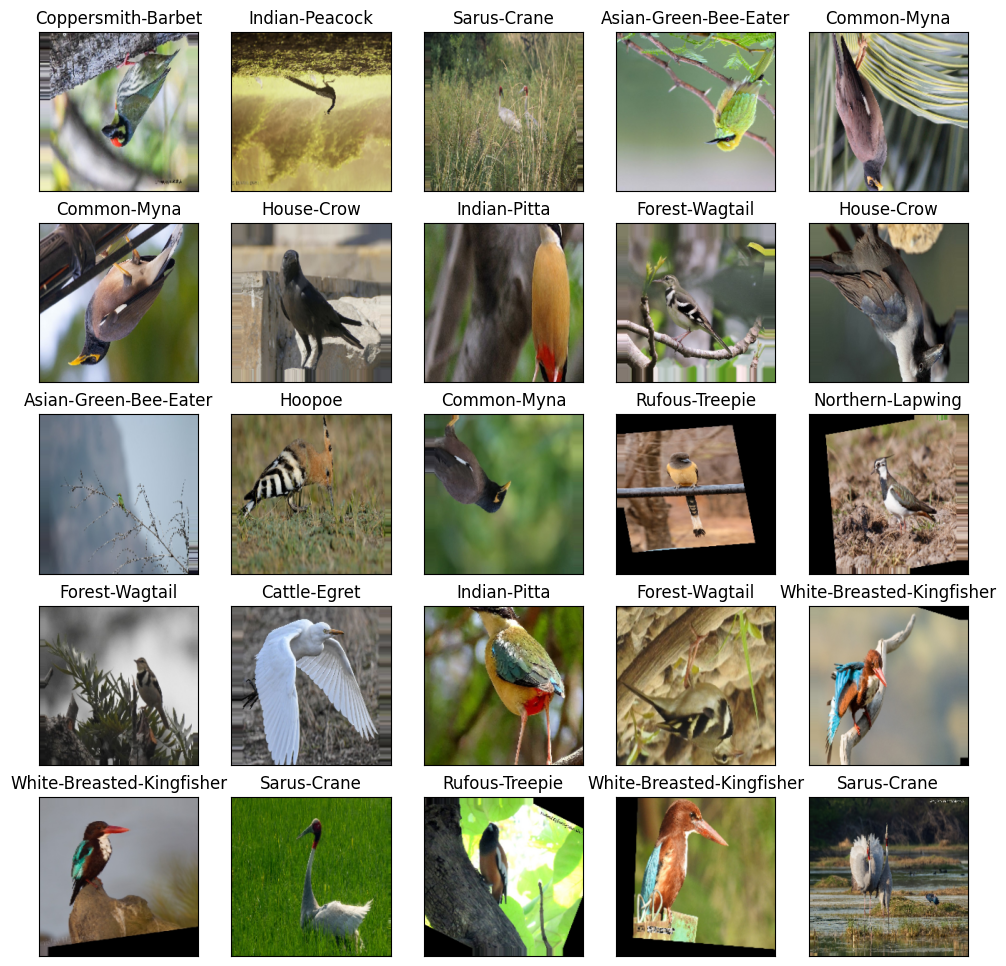

In [9]:
plt.tight_layout()
plt.figure(figsize=(12,12))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(temp[0][i])
  plt.title(f"{get_class(np.argmax(temp[1][i]))}")

In [10]:
conv_base = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

58889256/58889256 [==============================] - 2s 0us/step


In [11]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
for layer in conv_base.layers:
  if "block5" in layer.name:
    layer.trainable = True
  else:
    layer.trainable = False

In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
model = Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(4096, activation="silu"),
    layers.BatchNormalization(),
    layers.Dense(4096, activation="silu"),
    layers.BatchNormalization(),
    layers.Dense(25, activation="softmax")
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 batch_normalization (Batch  (None, 4096)              16384     
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 batch_normalization_1 (Bat  (None, 4096)              16384     
 chNormalization)                                       

In [16]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy'
              , metrics=['accuracy'])

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=1e-5, patience=3, verbose=1)

In [18]:
history = model.fit(train_gen, validation_data=test_gen, epochs=5, callbacks=[callback])

Epoch 1/5
938/938 [==============================] - 704s 735ms/step - loss: 1.3508 - accuracy: 0.6047 - val_loss: 0.7240 - val_accuracy: 0.7796
Epoch 2/5
938/938 [==============================] - 657s 701ms/step - loss: 0.4296 - accuracy: 0.8679 - val_loss: 0.5542 - val_accuracy: 0.8363
Epoch 3/5
938/938 [==============================] - 643s 686ms/step - loss: 0.2061 - accuracy: 0.9399 - val_loss: 0.4922 - val_accuracy: 0.8516
Epoch 4/5
938/938 [==============================] - 666s 710ms/step - loss: 0.1108 - accuracy: 0.9697 - val_loss: 0.4914 - val_accuracy: 0.8627
Epoch 5/5
938/938 [==============================] - 644s 686ms/step - loss: 0.0792 - accuracy: 0.9775 - val_loss: 0.4650 - val_accuracy: 0.8728


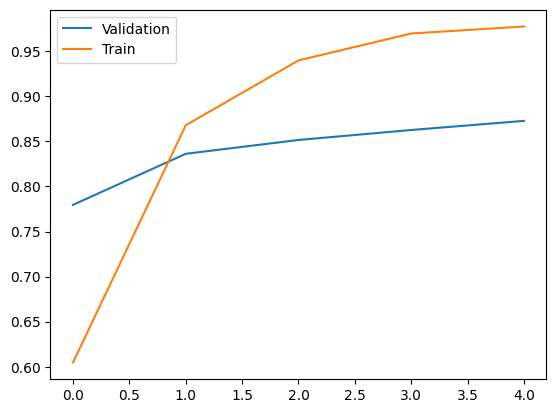

In [19]:
plt.plot(history.history['val_accuracy'], label='Validation')
plt.plot(history.history['accuracy'], label='Train')
plt.legend()
plt.show()

In [20]:
model.evaluate(test_gen)

235/235 [==============================] - 62s 262ms/step - loss: 0.4650 - accuracy: 0.8728


[0.4650198221206665, 0.8727999925613403]